In [2]:
import pandas as pd
from scipy.stats import ttest_rel, binomtest
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

In [222]:
df_fix = pd.read_csv(f"scores_7.csv")

In [242]:
len(df_scores)

93240

In [237]:
df_fix.groupby(["Type"]).count()

,Unnamed: 0,Model,Method,Subject,Trial,Speed,Band,Emb,Tau,Score
Type,,,,,,,,,,
0,0,5760,5760,5760,5760,5760,5760,5760,5760,5760
1,0,6120,6120,6120,6120,6120,6120,6120,6120,6120


In [233]:
df_fix.groupby([ "Emb", "Tau", "Band", "Type"]).count()

Unnamed: 0  Model  Method  Subject  Trial  Speed  Score
Emb Tau Band Type                                                         
0   0   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    0              0    360     360      360    360    360    360
        2    1              0    360     360      360    360    360    360
    1   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        2    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
1   0   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        2    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
    1   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        2    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
2   0   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    1              0    360     360      360    360    360    360
        2    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
    1   0    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        1    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360
        2    0              0    360     360      360    360    360    360
             1              0    360     360      360    360    360    360

In [3]:
mod_id = 0
df_scores = pd.read_csv(f"scores_{mod_id}.csv")
df_ttest = pd.read_csv(f"speed_ttest_results_{mod_id}.csv")
df_fdr = pd.read_csv(f"speed_ttest_FDR_results_{mod_id}.csv")

In [4]:
for mod_id in range(1,9):
    df_next = pd.read_csv(f"scores_{mod_id}.csv")
    df_scores = pd.concat([df_scores, df_next], ignore_index=True)

    
    df_next = pd.read_csv(f"speed_ttest_results_{mod_id}.csv")
    df_ttest = pd.concat([df_ttest, df_next], ignore_index=True)

    
    df_next = pd.read_csv(f"speed_ttest_FDR_results_{mod_id}.csv")
    df_fdr = pd.concat([df_fdr, df_next], ignore_index=True)

In [ ]:
# df_scores.to_csv("combined_scores.csv", index=False)
# df_ttest.to_csv("combined_ttest.csv", index=False)
# df_fdr.to_csv("combined_fdr.csv", index=False)


In [5]:
df_avg = (
    df_scores
    .groupby(['Model','Method','Subject','Speed','Band','Emb','Tau','Type'], as_index=False)
    ['Score']
    .mean()
)

# df_avg.to_csv("averaged_scores.csv", index=False)

In [134]:
df_scores.iloc[28438:35245]

,Model,Method,Subject,Trial,Speed,Band,Emb,Tau,Type,Score,Unnamed: 0
28438,3.0,3.0,7.0,22.0,0.0,2.0,2.0,1.0,0.0,0.995495,NaN
28439,3.0,3.0,7.0,22.0,1.0,2.0,2.0,1.0,0.0,0.975984,NaN
28440,4.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,0.035177,NaN
28441,4.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,0.179001,NaN
28442,4.0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.131041,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35240,4.0,3.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,0.018119,NaN
35241,4.0,3.0,7.0,3.0,0.0,2.0,1.0,1.0,1.0,0.468242,NaN
35242,4.0,3.0,7.0,3.0,1.0,2.0,1.0,1.0,1.0,-0.153610,NaN
35243,4.0,3.0,7.0,4.0,0.0,2.0,1.0,1.0,1.0,-0.019146,NaN


In [6]:
simple_df = pd.DataFrame(columns=["Model", "Method", "Subject", "Band", "Emb", "Tau", "Type", "Score_F", "Score_S", "Prop"])


brek = 0
rows = []
for mod_id in range(9):
    restricts = [(mid, 6*sid + 1, bid, eid, tid, tyd)
                for mid in range(4)
                for sid in range(2)
                for bid in range(3)
                for eid in range(3)
                for tid in range(2)
                for tyd in range(2)]
    for (mid, sid, bid, eid, tid, tyd) in restricts:
        if mod_id == 0:
            if bid + eid + tid + tyd > 0:
                continue
        elif mod_id == 1:
            if bid + tyd > 0:
                continue
        filtered_df = df_scores[(df_scores["Model"] == mod_id) & 
            (df_scores["Subject"] == sid) & 
            (df_scores["Band"] == bid) &
            (df_scores["Emb"] == eid) &
            (df_scores["Tau"] == tid) &
            (df_scores["Type"] == tyd) &
            (df_scores["Method"] == mid)
            ]
        try:
            avg_F = filtered_df.groupby("Speed", as_index=False)["Score"].mean().iloc[0]["Score"]
            avg_S = filtered_df.groupby("Speed", as_index=False)["Score"].mean().iloc[1]["Score"]
        except IndexError as e:
            print(f"Expected Error for Case {(mod_id, mid, sid, bid, eid, tid, tyd)}: {e}")
            print(filtered_df)
            brek = 1
            continue

        if brek:
            asodfjasdoij

        trues = 0
        tot = 0
        for t in range(22 + sid%7):
            try:
                # print(t)
                if filtered_df[filtered_df["Trial"] == t+1]["Score"].iloc[1] > filtered_df[filtered_df["Trial"] == t+1]["Score"].iloc[0]:
                    trues += 1
                tot += 1
            except IndexError as e:
                print(f"Expected Error for Case {(mod_id, mid, sid, bid, eid, tid, tyd)}: {e}")
                print(filtered_df)
                brek = 1
                continue

        if brek:
            asodfjasdoij

        
        row = {
            "Model": mod_id,
            "Method": mid,
            "Subject": sid,
            "Band": bid,
            "Emb": eid,
            "Tau": tid,
            "Type": tyd,
            "Score_F": avg_F,
            "Score_S": avg_S,
            "Prop": trues/tot
        }
        rows.append(row)

simple_df = pd.concat([simple_df, pd.DataFrame(rows)])

C:\Users\marti\AppData\Local\Temp\ipykernel_21212\1805274665.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  simple_df = pd.concat([simple_df, pd.DataFrame(rows)])


In [57]:
simple_df[(simple_df["Band"] != 2) & (simple_df["Model"] == 7)].groupby("Band").mean()

,Model,Method,Subject,Emb,Tau,Type,Score_F,Score_S,Prop
Band,,,,,,,,,
0,7.0,1.5,4.0,1.0,0.5,0.5,0.066976,0.077550,0.507843
1,7.0,1.5,4.0,1.0,0.5,0.5,0.060282,0.095252,0.557971


In [ ]:
mod_id = 2

auxd = simple_df[simple_df["Model"] == mod_id]
subd = auxd[(auxd["Type"] == 0) & (auxd["Emb"] == 1) & (auxd["Tau"] == 0) & (auxd["Band"] == 0)]

methods = ["Ridge", "Kernel Ridge", "PLSRegressor", "MLPRegressor"]
subjects = sorted(subd["Subject"].unique())
colors = ["C0", "C1"]   # ONLY two colors

# --- spacing configuration ---
bar_width = 0.20                 # width of each bar
subject_spacing = 0.30           # space between subjects
method_spacing = len(subjects) * (2*bar_width + subject_spacing) + 0.5

# Compute x positions for whole METHOD groups
method_positions = np.arange(len(methods)) * method_spacing

fig, ax = plt.subplots(figsize=(12, 6))

for i, method in enumerate(methods):
    df_m = subd[subd["Method"] == i]
    max_heit = max([subd["Score_F"].max(), subd["Score_S"].max()])

    # Base x position for this method block
    base_x = method_positions[i]

    for j, subject in enumerate(subjects):
        df_ms = df_m[df_m["Subject"] == subject].iloc[0]

        # Left position of this subject block
        subject_x = base_x + j * (2*bar_width + subject_spacing)

        f_val = df_ms["Score_F"]
        s_val = df_ms["Score_S"]

        # Plot Score_F
        ax.bar(
            subject_x,
            df_ms["Score_F"],
            width=bar_width,
            color=colors[0],
            label="Pearson Fast" if i==0 and j==0 else None
        )

        # Plot Score_S
        ax.bar(
            subject_x + bar_width,
            df_ms["Score_S"],
            width=bar_width,
            color=colors[1],
            label="Pearson Slow" if i==0 and j==0 else None
        )


        max_height = max(f_val, s_val)
        min_height = min(f_val, s_val)

        label_y = max_height + 0.07 * max_heit  if max_height > 0 else min_height + 0.07 * max_height

        midpoint = subject_x + bar_width * 0.5
        # print(label_y, max_heit)
        ax.text(
            midpoint,
            label_y,                     # a bit below zero (adjust if needed)
            f"Subject {"01" if subject == 1 else "79"}\nProportion: {df_ms["Prop"]:.2f}",
            ha='center',
            va='top',
            rotation=0,
            fontsize=9,
            # transform=ax.get_xaxis_transform()   # places text relative to x-axis
        )

# X-tick labels centered on each method group
ax.set_xticks(method_positions + method_spacing*0.25)
ax.set_xticklabels([f"Method {m}" for m in methods])

ax.set_ylabel("Score")
ax.set_title(f"Scores by Method for Model {mod_id}.")

ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
auxd = simple_df[simple_df["Model"] == mod_id]
subd = auxd[(auxd["Type"] == 0) & (auxd["Emb"] == 1) & (auxd["Tau"] == 0) & (auxd["Band"] == 0)]

,Model,Method,Subject,Band,Emb,Tau,Type,Score_F,Score_S,Prop
60,2,0,1,0,1,0,0,0.121594,0.180584,0.521739
96,2,0,7,0,1,0,0,0.065091,0.127979,0.500000
132,2,1,1,0,1,0,0,-0.012132,0.080597,0.565217
168,2,1,7,0,1,0,0,-0.041599,0.021233,0.500000
204,2,2,1,0,1,0,0,0.235688,0.264110,0.565217
240,2,2,7,0,1,0,0,0.120125,0.207397,0.590909
276,2,3,1,0,1,0,0,0.098439,0.150574,0.608696
312,2,3,7,0,1,0,0,0.036045,0.101216,0.590909


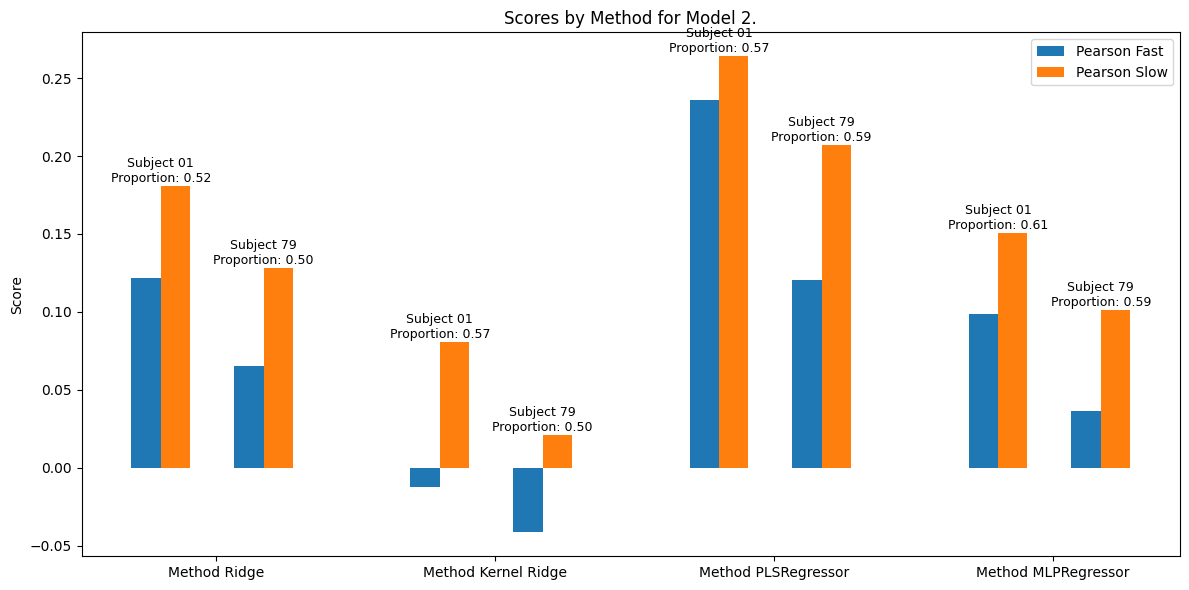

In [309]:
methods = ["Ridge", "Kernel Ridge", "PLSRegressor", "MLPRegressor"]
subjects = sorted(subd["Subject"].unique())
colors = ["C0", "C1"]   # ONLY two colors

# --- spacing configuration ---
bar_width = 0.20                 # width of each bar
subject_spacing = 0.30           # space between subjects
method_spacing = len(subjects) * (2*bar_width + subject_spacing) + 0.5

# Compute x positions for whole METHOD groups
method_positions = np.arange(len(methods)) * method_spacing

fig, ax = plt.subplots(figsize=(12, 6))

for i, method in enumerate(methods):
    df_m = subd[subd["Method"] == i]
    max_heit = max([subd["Score_F"].max(), subd["Score_S"].max()])

    # Base x position for this method block
    base_x = method_positions[i]

    for j, subject in enumerate(subjects):
        df_ms = df_m[df_m["Subject"] == subject].iloc[0]

        # Left position of this subject block
        subject_x = base_x + j * (2*bar_width + subject_spacing)

        f_val = df_ms["Score_F"]
        s_val = df_ms["Score_S"]

        # Plot Score_F
        ax.bar(
            subject_x,
            df_ms["Score_F"],
            width=bar_width,
            color=colors[0],
            label="Pearson Fast" if i==0 and j==0 else None
        )

        # Plot Score_S
        ax.bar(
            subject_x + bar_width,
            df_ms["Score_S"],
            width=bar_width,
            color=colors[1],
            label="Pearson Slow" if i==0 and j==0 else None
        )


        max_height = max(f_val, s_val)
        min_height = min(f_val, s_val)

        label_y = max_height + 0.07 * max_heit  if max_height > 0 else min_height + 0.07 * max_height

        midpoint = subject_x + bar_width * 0.5
        # print(label_y, max_heit)
        ax.text(
            midpoint,
            label_y,                     # a bit below zero (adjust if needed)
            f"Subject {"01" if subject == 1 else "79"}\nProportion: {df_ms["Prop"]:.2f}",
            ha='center',
            va='top',
            rotation=0,
            fontsize=9,
            # transform=ax.get_xaxis_transform()   # places text relative to x-axis
        )

# X-tick labels centered on each method group
ax.set_xticks(method_positions + method_spacing*0.25)
ax.set_xticklabels([f"Method {m}" for m in methods])

ax.set_ylabel("Score")
ax.set_title(f"Scores by Method for Model {mod_id}.")

ax.legend()
plt.tight_layout()
plt.show()


In [331]:
def plot_model_subplot(ax, subd, mod_id):
    methods = ["Ridge", "Kernel Ridge", "PLSRegressor", "MLPRegressor"]
    subjects = sorted(subd["Subject"].unique())
    colors = ["C0", "C1"]

    bar_width = 0.20
    subject_spacing = 0.30
    method_spacing = len(subjects) * (2*bar_width + subject_spacing) + 0.5

    method_positions = np.arange(len(methods)) * method_spacing

    max_heit = max(subd["Score_F"].max(), subd["Score_S"].max())
    min_heit = min(subd["Score_F"].min(), subd["Score_S"].min())

    for i, method in enumerate(methods):
        df_m = subd[subd["Method"] == i]
        base_x = method_positions[i]

        for j, subject in enumerate(subjects):
            df_ms = df_m[df_m["Subject"] == subject].iloc[0]

            subject_x = base_x + j * (2*bar_width + subject_spacing)

            f_val = df_ms["Score_F"]
            s_val = df_ms["Score_S"]

            # Bars
            ax.bar(subject_x, f_val, width=bar_width,
                   color=colors[0], label="Pearson Fast" if i==0 and j==0 else None)
            ax.bar(subject_x + bar_width, s_val, width=bar_width,
                   color=colors[1], label="Pearson Slow" if i==0 and j==0 else None)

            # Label positioning
            max_height = max(f_val, s_val)
            min_height = min(f_val, s_val)
            label_y = max_height + 0.07 * max_heit if max_height > 0 else min_height + 0.07 * max_height

            midpoint = subject_x + bar_width * 0.5

            # sizss = [8, 4, 1, 1, 1, 1, 1, 1, 1]

            ax.text(
                midpoint,
                label_y,
                f"Subject {'01' if subject==1 else '79'}\n"
                f"Prop: {df_ms['Prop']:.2f}",
                ha='center',
                va='top',
                fontsize=8,
            )

    # Method tick labels
    ax.set_xticks(method_positions + method_spacing * 0.25)
    ax.set_xticklabels(methods, fontsize=7, rotation=20)

    minnn = 0 if min_heit > 0 else min_heit * 1.1
    ax.set_ylim(minnn, max_heit * 1.1)

    # ax.set_title(f"Model {mod_id}", fontsize=12)
    ax.legend(fontsize=6)


In [336]:
for mod_id in range(9):

    if mod_id == 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        auxd = simple_df[simple_df["Model"] == mod_id]
        subd = auxd[(auxd["Type"] == 0) & (auxd["Emb"] == 0) & (auxd["Tau"] == 0) & (auxd["Band"] == 0)]
        plot_model_subplot(ax, subd, mod_id)
        ax.set_title(f"Model {mod_id}", fontsize=12)        
        fig.savefig(f"pngs/Barplot_Model{mod_id}.png")
        plt.tight_layout()
        plt.close()
    elif mod_id == 1:
        fig, axes = plt.subplots(3, 2, figsize=(36, 18))
        auxd = simple_df[simple_df["Model"] == mod_id]
        for eid in range(3):
            for tid in range(2):
                ax = axes[eid, tid]
                subd = auxd[(auxd["Type"] == 0) & (auxd["Emb"] == eid) & (auxd["Tau"] == tid) & (auxd["Band"] == 0)]
                plot_model_subplot(ax, subd, mod_id)
                ax.set_title(f"Window Size {np.array([30,50,64])[eid]}, Tau {10 if tid == 1 else 1}", fontsize=12)
        fig.suptitle(f"Model {mod_id}.", fontsize=21)
        
        fig.savefig(f"pngs/Barplot_Model{mod_id}.png")
        # plt.tight_layout()
        plt.close()
    else:
        fig, axes = plt.subplots(6, 6, figsize=(48, 24))
        auxd = simple_df[simple_df["Model"] == mod_id]
        for eid in range(3):
            for tid in range(2):
                for bid in range(3):
                    for tyd in range(2):
                        ax = axes[2*eid + tid, 2*bid + tyd]
                        subd = auxd[(auxd["Type"] == tyd) & (auxd["Emb"] == eid) & (auxd["Tau"] == tid) & (auxd["Band"] == bid)]
                        plot_model_subplot(ax, subd, mod_id)
                        ax.set_title(f"Window Size {np.array([30,50,64])[eid]}, Tau {10 if tid == 1 else 1}, Band {["Alpha", "Theta", "Beta"][bid]} and Type {"Sphere" if tyd == 0 else "Square"}", fontsize=12)
        fig.suptitle(f"Model {mod_id}.", fontsize=27)
        fig.savefig(f"pngs/Barplot_Model{mod_id}.png")
        # plt.tight_layout()
        plt.close()
    

In [339]:
df_avg[df_avg["Model"] == 0].groupby("Speed").mean()

,Model,Method,Subject,Band,Emb,Tau,Type,Score
Speed,,,,,,,,
0.0,0.0,1.5,4.0,0.0,0.0,0.0,0.0,0.114294
1.0,0.0,1.5,4.0,0.0,0.0,0.0,0.0,0.143837


In [348]:
df_ttest["P_value"]

0       0.312327
1       0.242038
2       0.448950
3       0.277304
4       0.121885
          ...   
2067    0.965613
2068    0.956424
2069    0.441588
2070    0.971193
2071    0.406214
Name: P_value, Length: 2072, dtype: float64

In [351]:
df_ttest[(df_ttest["Model"] == 2) & (df_ttest["P_value"] < 0.05)]

,Model,Method,Band,Emb,Tau,Type,Subject,NumPairs,T_stat,P_value,FastMean,SlowMean
84,2.0,0.0,1.0,0.0,1.0,0.0,1.0,23,1.982885,0.030002,-0.028093,0.116517
106,2.0,0.0,2.0,0.0,0.0,1.0,1.0,23,2.669614,0.007000,0.002451,0.189045
108,2.0,0.0,2.0,0.0,1.0,0.0,1.0,23,2.338817,0.014417,0.007104,0.187825
110,2.0,0.0,2.0,0.0,1.0,1.0,1.0,23,2.798132,0.005240,-0.046851,0.173645
112,2.0,0.0,2.0,1.0,0.0,0.0,1.0,23,1.784929,0.044035,0.011281,0.136919
114,2.0,0.0,2.0,1.0,0.0,1.0,1.0,23,2.612485,0.007950,-0.013302,0.178588
116,2.0,0.0,2.0,1.0,1.0,0.0,1.0,23,2.230951,0.018099,0.000240,0.168614
118,2.0,0.0,2.0,1.0,1.0,1.0,1.0,23,2.508871,0.009988,-0.038456,0.160668
120,2.0,0.0,2.0,2.0,0.0,0.0,1.0,23,1.906103,0.034892,0.008403,0.142924
122,2.0,0.0,2.0,2.0,0.0,1.0,1.0,23,2.621376,0.007794,-0.015250,0.176450


In [24]:
methods = ["Ridge", "RBF Kernel Ridge", "PLSRegressor", "MLPRegressor"]

for i in range(4):
    for s in range(2):
        speed_df = df_scores[df_scores["Speed"] == s]
        for m in range(2):
            bb = m*6 + 1
            aux_df = speed_df[speed_df["Subject"] == bb]
            print(f"Average Score for Subject {bb} on Speed {"fast" if s == 0 else "slow"} with Method {methods[i]} is {aux_df.groupby("Method").mean().iloc[i]["Score"]}")

Average Score for Subject 1 on Speed fast with Method Ridge is 0.1412365624724109
Average Score for Subject 7 on Speed fast with Method Ridge is 0.10296172554528628
Average Score for Subject 1 on Speed slow with Method Ridge is 0.16360780910427072
Average Score for Subject 7 on Speed slow with Method Ridge is 0.15159665086318833
Average Score for Subject 1 on Speed fast with Method RBF Kernel Ridge is 0.05960196280142734
Average Score for Subject 7 on Speed fast with Method RBF Kernel Ridge is 0.006199789320346433
Average Score for Subject 1 on Speed slow with Method RBF Kernel Ridge is 0.0660532885186363
Average Score for Subject 7 on Speed slow with Method RBF Kernel Ridge is 0.04991955043297443
Average Score for Subject 1 on Speed fast with Method PLSRegressor is 0.16495553457768422
Average Score for Subject 7 on Speed fast with Method PLSRegressor is 0.16160999814574561
Average Score for Subject 1 on Speed slow with Method PLSRegressor is 0.20209092614229282
Average Score for Subje